In [1]:
import pandas as pd
import numpy as np

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import median
from sklearn.utils import resample

# ALGOS
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm


from sklearn import metrics
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve



import warnings

warnings.filterwarnings('ignore')

In [ ]:
# !pip install imbalanced-learn

In [2]:
modelling_df = pd.read_csv('../data/sinave4.csv')

In [3]:
modelling_df.shape

(341990, 74)

In [ ]:
# modelling_df.info()

In [ ]:
modelling_df['estado'].value_counts(normalize = True)

In [ ]:
# modelling_df['estado'].value_counts()

In [ ]:
ax = modelling_df['estado'].value_counts().plot(kind='bar', figsize=(10, 6), fontsize=13, color='#087E8B')
ax.set_title('Estado', size=20, pad=30)
ax.set_ylabel('Número de casos', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.10, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=15)

In [ ]:
sintomas_list = ['fiebre', 'tos','odinofagia','disnea','irritabilidad','diarrea','dolor_toracico','calofrios', 'cefalea','mialgias','artralgias','ataque_al_estado_general','rinorrea','polipnea','vomito','dolor_abdominal','conjuntivitis','cianosis']
patologias_list = ['diabetes', 'epoc', 'asma', 'inmunosupresivo','hipertension', 'VIH_SIDA', 'otra_condicion', 'enfermedad_cardiaca','obesidad', 'insuficiencia_renal_cronica', 'tabaquismo']

In [ ]:
# modelling_df3 = modelling_df.copy()

In [10]:
modelling_df3_2cat = modelling_df.copy()

In [ ]:
# modelling_df3_2cat['estado'].replace(to_replace=['ACTIVOS LEVES', 'RECUPERADOS', 'FALLECIDOS', 'ACTIVOS GRAVES'],value=['RECUPERADOS','RECUPERADOS','FALLECIDOS','FALLECIDOS'],inplace=True)

In [11]:
modelling_df3_2cat = modelling_df3_2cat[modelling_df3_2cat["estado"].isin(['RECUPERADOS','FALLECIDOS'])]

In [12]:
modelling_df3_2cat.estado.unique()

array(['RECUPERADOS', 'FALLECIDOS'], dtype=object)

In [13]:
# Convert to dummies
modelling_df3_2cat['estado'].replace(to_replace=['RECUPERADOS', 'FALLECIDOS'], 
                                     value=[1,0],inplace=True)

# BALANCED MULTICLASS 

### SMOTE

In [14]:
sm = SMOTE(random_state = 42)

In [15]:
features = ['fiebre', 'tos','odinofagia','disnea','irritabilidad','diarrea','dolor_toracico','calofrios', 'cefalea','mialgias','artralgias','ataque_al_estado_general','rinorrea','polipnea','vomito','dolor_abdominal','conjuntivitis','cianosis','diabetes', 'epoc', 'asma', 'inmunosupresivo','hipertension', 'VIH_SIDA', 'otra_condicion', 'enfermedad_cardiaca','obesidad', 'insuficiencia_renal_cronica', 'tabaquismo', 'diabetes', 'epoc', 'asma', 'inmunosupresivo',
       'hipertension', 'VIH_SIDA', 'otra_condicion', 'enfermedad_cardiaca',
       'obesidad', 'insuficiencia_renal_cronica', 'tabaquismo']

In [17]:
X = modelling_df3_2cat[features].copy()
y = modelling_df3_2cat['estado'].copy()

In [18]:
X = np.array(X)

In [19]:
X, y = sm.fit_resample(X, y)

In [20]:
from collections import Counter
counter = Counter(y)

for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=1, n=154526 (50.000%)
Class=0, n=154526 (50.000%)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (247241, 40) (247241,)
Test set: (61811, 40) (61811,)


In [22]:
# estandarizamos los datos

ss = preprocessing.StandardScaler().fit(X_train.astype(np.float))
X_train = ss.transform(X_train.astype(np.float))
X_test = ss.transform(X_test.astype(np.float))

## Logistic Regression Classifier multiclass

In [23]:
# Confusion Matrix plotting function
# https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


### OPTIMIZE FOR RMSE

In [24]:
# Encuentra los mejores hiperparámetros para logistic regression classifier
#Logistic Regression soporta solo solvers en ['liblinear', 'newton-cg'<-93.44, 'lbfgs'<-91.8, 'sag'<-72.13, 'saga'<-72.13]

solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']
cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
results_df = pd.DataFrame(index=cs)
results_df.index.name='C'
for s in solvers:
    results = []
    for c in cs:
        LR = LogisticRegression(C=c, solver=s, max_iter=4000, random_state=42).fit(X_train,y_train)
        y_pred = LR.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse_lr = mean_squared_error(y_test, y_pred)**0.5
        results.append(rmse_lr)
    results_df[s] = results
results_df

,newton-cg,lbfgs,sag,saga
C,,,,
0.0001,0.438958,0.438958,0.438976,0.438976
0.0010,0.437703,0.437703,0.437685,0.437685
0.0100,0.437814,0.437814,0.437832,0.437814
0.1000,0.437869,0.437869,0.437888,0.437869
1.0000,0.437888,0.437888,0.437832,0.437888
10.0000,0.437888,0.437888,0.437851,0.437888
100.0000,0.437888,0.437888,0.437851,0.437888


Confusion matrix, without normalization


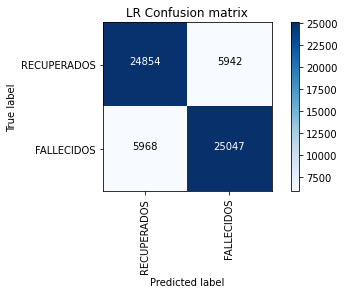

In [28]:
import itertools


# Ejecutamos logistic regression classifier y mostramos resultados

LR = LogisticRegression(C=0.0001, solver='newton-cg', random_state=42).fit(X_train,y_train)
y_pred = LR.predict(X_test)
y_pred_train = LR.predict(X_train)


LR_RMSE = mean_squared_error(y_test, y_pred)**0.5
LR_RMSE_train = mean_squared_error(y_train, y_pred_train)**0.5

LR_f_score = f1_score(y_test, y_pred, average='micro')
LR_f_score_train = f1_score(y_train, y_pred_train, average='micro')

LR_class_report = classification_report(y_test, y_pred)
LR_class_report_train = classification_report(y_train, y_pred_train)

LR_dict = classification_report(y_test, y_pred, output_dict=True)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['RECUPERADOS', 'FALLECIDOS'],normalize=False,  title='LR Confusion matrix')

In [29]:

print('Logistic Regression train RMSE:', round(LR_RMSE_train, 4))
print('Logistic Regression test RMSE:', round(LR_RMSE, 4))

print('\nLogistic Regression TRAIN classification report:\n\n', LR_class_report_train)
print('Logistic Regression TEST classification report:\n\n', LR_class_report)

Logistic Regression train RMSE: 0.4367
Logistic Regression test RMSE: 0.439

Logistic Regression TRAIN classification report:

               precision    recall  f1-score   support

           0       0.81      0.81      0.81    123511
           1       0.81      0.81      0.81    123730

    accuracy                           0.81    247241
   macro avg       0.81      0.81      0.81    247241
weighted avg       0.81      0.81      0.81    247241

Logistic Regression TEST classification report:

               precision    recall  f1-score   support

           0       0.81      0.81      0.81     31015
           1       0.81      0.81      0.81     30796

    accuracy                           0.81     61811
   macro avg       0.81      0.81      0.81     61811
weighted avg       0.81      0.81      0.81     61811



### OPTIMIZE FOR ACCURACY

In [31]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
results_df = pd.DataFrame(index=cs)
results_df.index.name='C'
for s in solvers:
    results = []
    for c in cs:
        LR = LogisticRegression(C=c, solver=s, max_iter=4000, random_state=42).fit(X_train,y_train)
        yhat = LR.predict(X_test)
        j_score = jaccard_score(y_test, y_pred)
        results.append(j_score)
    results_df[s] = results
results_df

,newton-cg,lbfgs,liblinear,sag,saga
C,,,,,
0.0001,0.676042,0.676042,0.676042,0.676042,0.676042
0.0010,0.676042,0.676042,0.676042,0.676042,0.676042
0.0100,0.676042,0.676042,0.676042,0.676042,0.676042
0.1000,0.676042,0.676042,0.676042,0.676042,0.676042
1.0000,0.676042,0.676042,0.676042,0.676042,0.676042
10.0000,0.676042,0.676042,0.676042,0.676042,0.676042
100.0000,0.676042,0.676042,0.676042,0.676042,0.676042


Confusion matrix, without normalization


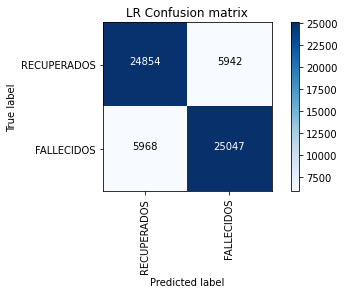

In [35]:
import itertools


# Ejecutamos logistic regression classifier y mostramos resultados

LR = LogisticRegression(C=0.0001, solver='newton-cg', random_state=42).fit(X_train,y_train)
y_pred = LR.predict(X_test)
y_pred_train = LR.predict(X_train)

LR_j_score = jaccard_score(y_test, y_pred)
LR_j_score_train = jaccard_score(y_train, y_pred_train)

LR_f_score = f1_score(y_test, y_pred, average='weighted')
LR_f_score_train = f1_score(y_train, y_pred_train, average='weighted')

LR_class_report = classification_report(y_test, y_pred)
LR_class_report_train = classification_report(y_train, y_pred_train)

LR_dict = classification_report(y_test, y_pred, output_dict=True)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['RECUPERADOS','FALLECIDOS'],normalize=False,  title='LR Confusion matrix')

In [36]:
print('Logistic Regression train jaccard score:', round(LR_j_score_train, 4))
print('Logistic Regression test jaccard score:', round(LR_j_score, 4))

print('\nLogistic Regression train classification report:\n\n', LR_class_report_train)
print('Logistic Regression test classification report:\n\n', LR_class_report)

Logistic Regression train jaccard score: 0.6798
Logistic Regression test jaccard score: 0.676

Logistic Regression train classification report:

               precision    recall  f1-score   support

           0       0.81      0.81      0.81    123511
           1       0.81      0.81      0.81    123730

    accuracy                           0.81    247241
   macro avg       0.81      0.81      0.81    247241
weighted avg       0.81      0.81      0.81    247241

Logistic Regression test classification report:

               precision    recall  f1-score   support

           0       0.81      0.81      0.81     31015
           1       0.81      0.81      0.81     30796

    accuracy                           0.81     61811
   macro avg       0.81      0.81      0.81     61811
weighted avg       0.81      0.81      0.81     61811



## Decision Tree Classifier

In [ ]:
# Encuentra los mejores hiperparámetros para el decision tree classifier

#Usamos Cross Validation para encontrar la profundidad que de la precisión óptima

depth = 20 #20
mean_sqe = np.zeros((depth-1))
for n in range(1,depth): 
    DT = DecisionTreeClassifier(criterion="entropy", max_depth = n, random_state=42).fit(X_train,y_train)
    y_pred=DT.predict(X_test)
    
    mean_sqe[n-1] = mean_squared_error(y_test, y_pred)**0.5
plt.plot(range(1,depth),mean_sqe,'g')
plt.ylabel('RMSE')
plt.xlabel('Depth')
plt.show()
print("The best RMSE is", round(mean_sqe.min(), 4), "with depth=", mean_sqe.argmin()+1)

In [ ]:
DT = DecisionTreeClassifier(criterion="entropy", max_depth = 5, random_state=42).fit(X_train, y_train)
y_pred = LR.predict(X_test)
y_pred_train = LR.predict(X_train)


LR_RMSE = mean_squared_error(y_test, y_pred)**0.5
LR_RMSE_train = mean_squared_error(y_train, y_pred_train)**0.5

LR_f_score = f1_score(y_test, y_pred, average='micro')
LR_f_score_train = f1_score(y_train, y_pred_train, average='micro')

LR_class_report = classification_report(y_test, y_pred)
LR_class_report_train = classification_report(y_train, y_pred_train)

LR_dict = classification_report(y_test, yhat, output_dict=True)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2,3])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['ACTIVOS LEVES','ACTIVOS GRAVES','RECUPERADOS', 'FALLECIDOS'],normalize=False,  title='LR Confusion matrix')

In [ ]:

print('Logistic Regression train RMSE:', round(LR_RMSE_train, 4))
print('Logistic Regression test RMSE:', round(LR_RMSE, 4))

print('\nLogistic Regression TRAIN classification report:\n\n', LR_class_report_train)
print('Logistic Regression TEST classification report:\n\n', LR_class_report)

In [ ]:
# import graphviz
# import numpy as np
# from sklearn.tree import DecisionTreeClassifier
# from sklearn import tree
# from sklearn.model_selection import train_test_split
# from pandas import DataFrame, Series
# from IPython.display import Image 
# from io import StringIO
# import pydotplus
# from sklearn import preprocessing
# from sklearn.tree import export_graphviz

In [ ]:
# DecsTree = DecisionTreeClassifier(criterion='entropy', max_depth=7)
# DecsTree.fit(X,y)
# dot_data = StringIO()
# fn=['sexo','diabetes', 'epoc', 'asma', 'inmunosupresivo','hipertension', 'vihsida', 'otra_condicion', 'enfermedad_cardiaca','obesidad', 'insuficiencia_renal_cronica', 'tabaquismo','edad']
# cn=['Fallecidos','Recuperados']


# export_graphviz(DecsTree, out_file=dot_data,
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names = fn, class_names=cn)
        
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.set_size('"300,180!"')
# graph.write_png('Decision Tree graph.jpg')
# Image(graph.create_png())

## Random Forest Classifier

In [ ]:
# buscamos los mejores hiperparámetros para Random Forest Classifier, incrementos de 50

depth = 700
mean_acc = np.zeros((depth-1))
for n in range(1,depth,50): 
    RF = RandomForestClassifier(n_estimators=n, random_state=42).fit(X_train,y_train)
    y_pred=RF.predict(X_test)
    
    mean_acc[n-1] = mean_squared_error(y_test, y_pred)**0.5
plt.plot(range(1,depth,50),mean_sqr[::50],'g')
plt.ylabel('RMSE')
plt.xlabel('n_estimators')
plt.show()
print( "The best RMSE is", round(mean_sqr.min(), 4), "with n_estimators =", mean_sqr.argmin()+1)

In [ ]:
# buscamos los mejores hiperparámetros para Random Forest Classifier, incrementos de 50
#Reducimos los n_estimators previamente al rango 50-250

depth = 500

mean_sqr = np.zeros((depth-1))
for n in range(400,depth,10): 
    RF = RandomForestClassifier(n_estimators=n, random_state=42).fit(X_train,y_train)
    y_pred=RF.predict(X_test)
    mean_sqr[n-1] = mean_squared_error(y_test, y_pred)**0.5
plt.plot(range(1,depth,50),mean_sqr[::50],'g')
plt.ylabel('RMSE')
plt.xlabel('n_estimators')
plt.show()
print( "The best RMSE is", round(mean_sqr.min(), 4), "with n_estimators =", mean_sqr.argmin()+1)

In [ ]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train , y_train)
accuracies = cross_val_score(estimator = clf_rf, X = X_train, y = y_train, cv = 5,verbose = 1)
y_pred = clf_rf.predict(X_test)
print('')
print('###### Random Forest ######')
print('Score : %.4f' % clf_rf.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_rf = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse_rf)



In [ ]:
no_of_test=[100]
params_dict={'n_estimators':no_of_test,'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator = RandomForestClassifier(),param_grid=params_dict, scoring='neg_root_mean_squared_error')
clf_rf.fit(X_train,y_train)
pred = clf_rf.predict(X_test)


rmse = mean_squared_error(y_test, pred)**0.5

print('RMSE     : %0.2f ' % rmse)